# Building Residual Networks in Keras

In theory, very deep networks can represent very complex functions; but in practice, they are hard to train. Residual Networks, allow you to train much deeper networks than were previously practically feasible.

- Implement the basic building blocks of ResNets. 
- Put together these building blocks to implement and train a state-of-the-art neural network for image classification. 

Load the required packages.

In [1]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/TP4/ResNets_Microsoft')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

## 1 - The problem of very deep neural networks

Neural networks have become deeper, with state-of-the-art networks of over a hundred layers.

Very deep networks can represent very complex functions. However, a huge barrier to training them is vanishing gradients: very deep networks often have a gradient signal that goes to zero quickly.

During training, you might see the gradient magnitude for the earlier layers descrease to zero very rapidly: 

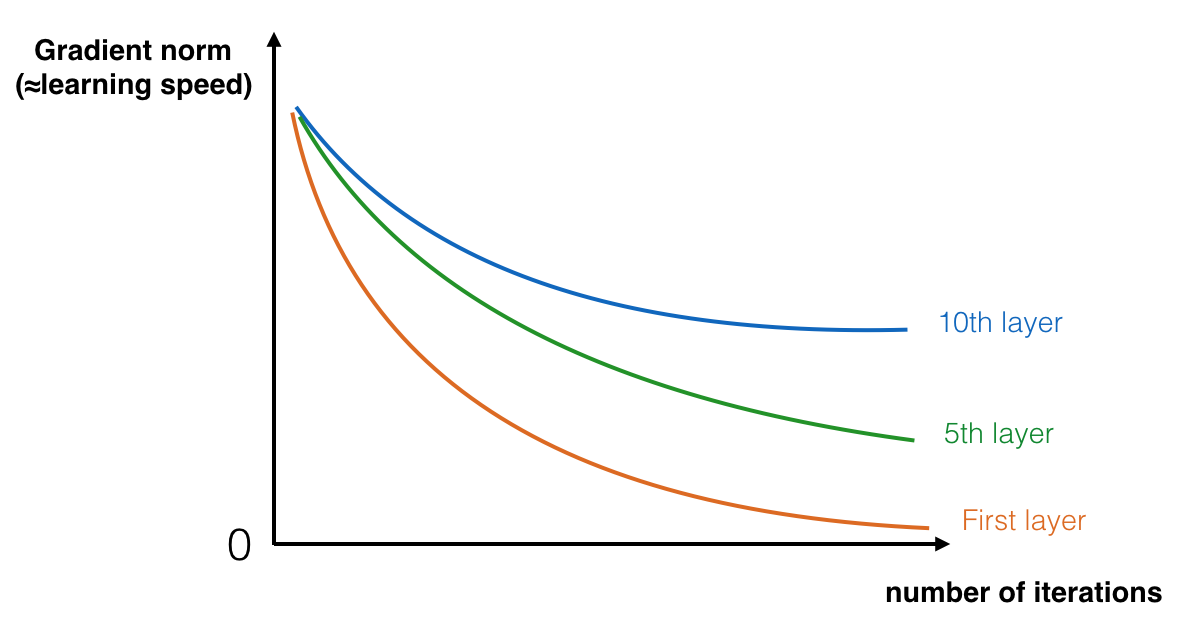

In [0]:
from IPython.display import Image
Image("images/vanishing_grad_kiank.png",width=800)

 **Figure 1** : **Vanishing gradient** The speed of learning decreases very rapidly for the early layers as the network trains </center></caption>


<font color='red'> Question: what are the reason and the consequence of this problem? </font>
<font color='blue'> Puisque la vitesse d'apprentissage décroît rapidement pour les premières couches, cela veut dire que la descente de gradient décroît fortement vers zéro. Ainsi, l'apprentissage ne se fait plus et nous n'avons plus l'actualisation des paramètres.</font>


You are now going to solve this problem by building a Residual Network!

## 2 - Building a Residual Network

In ResNets, a "shortcut" or a "skip connection" allows the gradient to be directly backpropagated to earlier layers: 

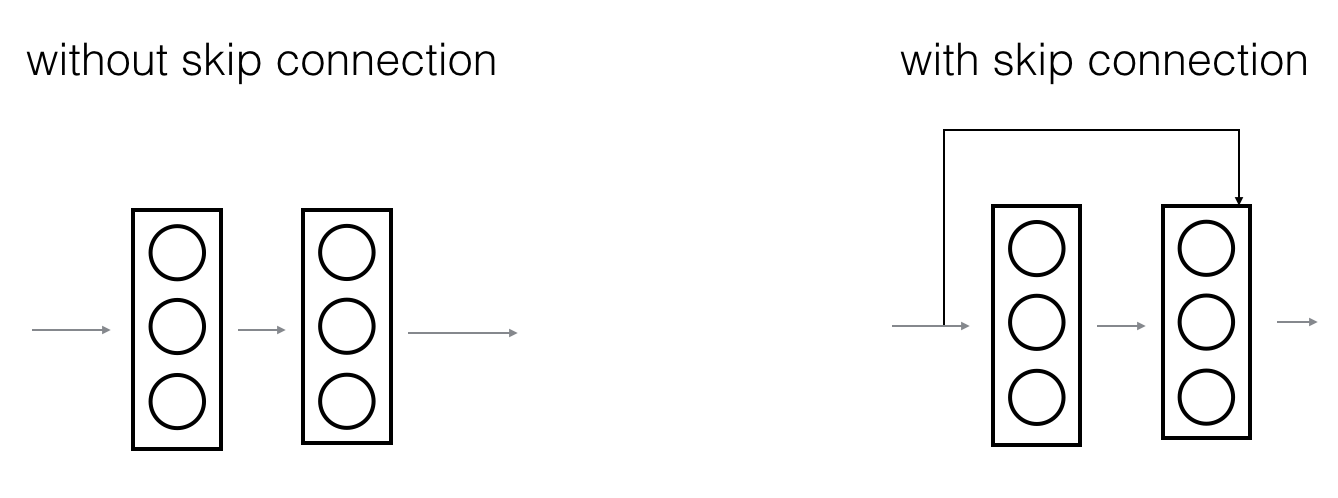

In [0]:
Image("images/skip_connection_kiank.png",width=800)

**Figure 2**: A ResNet block showing a **skip-connection** 

The image on the left shows the "main path" through the network. The image on the right adds a shortcut to the main path. By stacking these ResNet blocks on top of each other, you can form a very deep network. 

Two main types of blocks are used in a ResNet, depending mainly on whether the input/output dimensions are same or different.

### 2.1 - The identity block

The identity block is the standard block used in ResNets: input activation ($a^{[l]}$) has the same dimension as the output activation ($a^{[l+2]}$). 

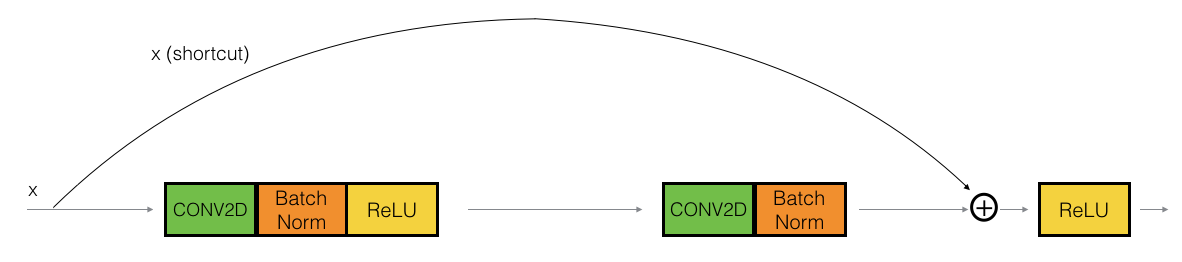

In [0]:
Image("images/idblock2_kiank.png",width=800)

**Figure 3**: **Identity block.** Skip connection "skips over" 2 layers.
    
You'll  impement a slightly more powerful version of this identity block: "skip over" 3 hidden layers rather than 2 layers: 


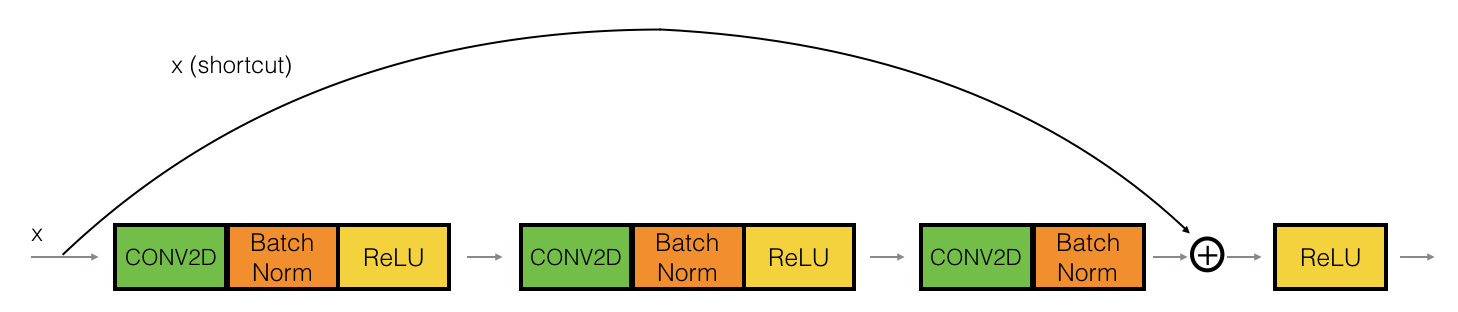

In [0]:
Image("images/idblock3_kiank.png",width=800)

 **Figure 4** : **Identity block.** Skip connection "skips over" 3 layers.

First component of main path: 
- CONV2D has $F_1$ filters of shape (1,1) and a stride of (1,1), padding: "valid", name: `conv_name_base + '2a'`. Use 0 as the seed for the random initialization. 
- BatchNorm is normalizing the channels axis, name: `bn_name_base + '2a'`.
- ReLU activation function. 

Second component of main path:
- CONV2D has $F_2$ filters of shape $(f,f)$ and a stride of (1,1), padding: "same", name: `conv_name_base + '2b'`. Use 0 as the seed for the random initialization. 
- BatchNorm, name:`bn_name_base + '2b'`.
- ReLU activation function. 

Third component of main path:
- CONV2D has $F_3$ filters of shape (1,1) and a stride of (1,1), padding: "valid", name: `conv_name_base + '2c'`. Use 0 as the seed for the random initialization. 
- BatchNorm, name: `bn_name_base + '2c'`. Note that there is no ReLU activation function. 

Final step: 
- The shortcut and the input are added together.
- ReLU activation function.

**Exercise**: Implement the ResNet identity block. We have implemented the first component of the main path. You should implement the rest. 
- To implement the Conv2D step: [See reference](https://keras.io/layers/convolutional/#conv2d)
- To implement BatchNorm: [See reference](https://faroit.github.io/keras-docs/1.2.2/layers/normalization/) (axis: Integer, the axis that should be normalized (typically the channels axis))
- For the activation, use:  `Activation('relu')(X)`
- To add the value passed forward by the shortcut: [See reference](https://keras.io/layers/merge/#add)

In [0]:
# GRADED FUNCTION: identity_block

def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines), kernel_size=(f,f)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    
    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut, X]) 
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [6]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(1)
    A_prev = tf.placeholder("float", [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    A = identity_block(A_prev, f = 2, filters = [2, 4, 6], stage = 1, block = 'a')
    test.run(tf.global_variables_initializer())
    out = test.run([A], feed_dict={A_prev: X, K.learning_phase(): 0})
    print("out = " + str(out[0][1][1][0]))

out = [0.9482299 0.        1.1610144 2.747859  0.        1.36677  ]


**Expected Output**:

<table>
    <tr>
        <td>
            **out**
        </td>
        <td>
           [ 0.94822985  0.          1.16101444  2.747859    0.          1.36677003]
        </td>
    </tr>

</table>

## 2.2 - The convolutional block

The ResNet "convolutional block" is the other type of block (use this type of block when the input and output dimensions don't match up). There is a CONV2D layer in the shortcut path: 

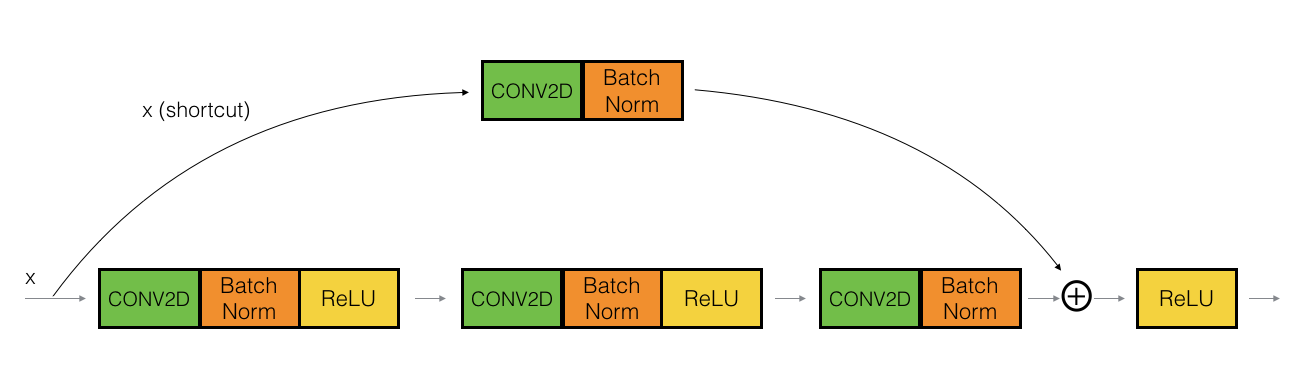

In [0]:
Image("images/convblock_kiank.png",width=800)

 **Figure 4** : **Convolutional block** 

The CONV2D layer is used to resize the input $x$ to a different dimension. For example, to reduce the activation dimensions's height and width by a factor of 2, you can use a 1x1 convolution with a stride of 2. The CONV2D layer on the shortcut path does not use any non-linear activation function.



First component of main path:
- CONV2D has $F_1$ filters of shape (1,1) and a stride of (s,s), padding: "valid", name: `conv_name_base + '2a'`. 
- BatchNorm, name: `bn_name_base + '2a'`.
- ReLU activation function.  

Second component of main path:
- CONV2D has $F_2$ filters of (f,f) and a stride of (1,1), padding: "same", name: `conv_name_base + '2b'`.
- BatchNorm is normalizing the channels axis, name: `bn_name_base + '2b'`.
- ReLU activation function. 

Third component of main path:
- CONV2D has $F_3$ filters of (1,1) and a stride of (1,1), padding: "valid", name: `conv_name_base + '2c'`.
- BatchNorm, name: `bn_name_base + '2c'`. Note that there is no ReLU activation function in this component. 

Shortcut path:
- CONV2D has $F_3$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid" and its name should be `conv_name_base + '1'`.
- BatchNorm (`bn_name_base + '1'`). 

Final step: 
- The shortcut and the main path values are added together.
- ReLU activation function
    
**Exercise**: Implement the convolutional block. Always use 0 as the seed for the random initialization.
- [Conv Hint](https://keras.io/layers/convolutional/#conv2d)
- [BatchNorm Hint](https://keras.io/layers/normalization/#batchnormalization) (axis: Integer, the axis that should be normalized (typically the features axis))
- For the activation, use:  `Activation('relu')(X)`
- [Addition Hint](https://keras.io/layers/merge/#add)

In [0]:
# GRADED FUNCTION: convolutional_block

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)
    
    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [9]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(1)
    A_prev = tf.placeholder("float", [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    A = convolutional_block(A_prev, f = 2, filters = [2, 4, 6], stage = 1, block = 'a')
    test.run(tf.global_variables_initializer())
    out = test.run([A], feed_dict={A_prev: X, K.learning_phase(): 0})
    print("out = " + str(out[0][1][1][0]))

out = [0.09018461 1.2348977  0.46822017 0.0367176  0.         0.655166  ]


**Expected Output**:

<table>
    <tr>
        <td>
            **out**
        </td>
        <td>
           [ 0.09018463  1.23489773  0.46822017  0.0367176   0.          0.65516603]
        </td>
    </tr>

</table>

## 3 - Building your ResNet model (50 layers) 

ResNet was invented by Microsoft with different versions.

"ID BLOCK" stands for "Identity block," and "ID BLOCK x3" means you should stack 3 identity blocks together.

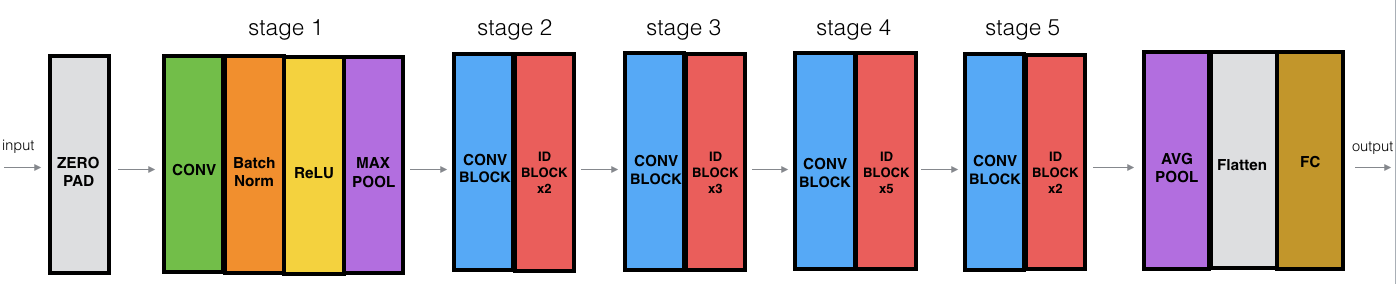

In [0]:
Image("images/resnet_kiank.png")

**Figure 5** : **ResNet-50 model**

- Zero-padding pads the input with a pad of (3,3)
- Stage 1:
    - The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2), name: "conv1".
    - BatchNorm is applied to the channels axis of the input.
    - MaxPooling uses a (3,3) window and a (2,2) stride.
- Stage 2:
    - The convolutional block uses three set of filters of size [64,64,256], "f" is 3, "s" is 1 and the block is "a".
    - The 2 identity blocks use three set of filters of size [64,64,256], "f" is 3 and the blocks are "b" and "c".
- Stage 3:
    - The convolutional block uses three set of filters of size [128,128,512], "f" is 3, "s" is 2 and the block is "a".
    - The 3 identity blocks use three set of filters of size [128,128,512], "f" is 3 and the blocks are "b", "c" and "d".
- Stage 4:
    - The convolutional block uses three set of filters of size [256, 256, 1024], "f" is 3, "s" is 2 and the block is "a".
    - The 5 identity blocks use three set of filters of size [256, 256, 1024], "f" is 3 and the blocks are "b", "c", "d", "e" and "f".
- Stage 5:
    - The convolutional block uses three set of filters of size [512, 512, 2048], "f" is 3, "s" is 2 and the block is "a".
    - The 2 identity blocks use three set of filters of size [256, 256, 2048], "f" is 3 and the blocks are "b" and "c".
- The 2D Average Pooling uses a window of shape (2,2) and its name is "avg_pool".
- The flatten doesn't have any hyperparameters or name.
- The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation. Its name should be `'fc' + str(classes)`.

**Exercise**: Implement the ResNet with 50 layers described in the figure above. 

- Average pooling [see reference](https://keras.io/layers/pooling/#averagepooling2d)
- Conv2D: [See reference](https://keras.io/layers/convolutional/#conv2d)
- BatchNorm: [See reference](https://keras.io/layers/normalization/#batchnormalization) (axis: Integer, the axis that should be normalized (typically the features axis))
- Zero padding: [See reference](https://keras.io/layers/convolutional/#zeropadding2d)
- Max pooling: [See reference](https://keras.io/layers/pooling/#maxpooling2d)
- Fully conected layer: [See reference](https://keras.io/layers/core/#dense)
- Addition: [See reference](https://keras.io/layers/merge/#add)

In [0]:
# GRADED FUNCTION: ResNet50

def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
    
    # Stage 5 (≈3 lines)
    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    
    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

Run the following code to build the model's graph. If your implementation is not correct you will know it by checking your accuracy when running `model.fit(...)` below.

In [12]:
model = ResNet50(input_shape = (64, 64, 3), classes = 6)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Let's load the SIGNS Dataset.

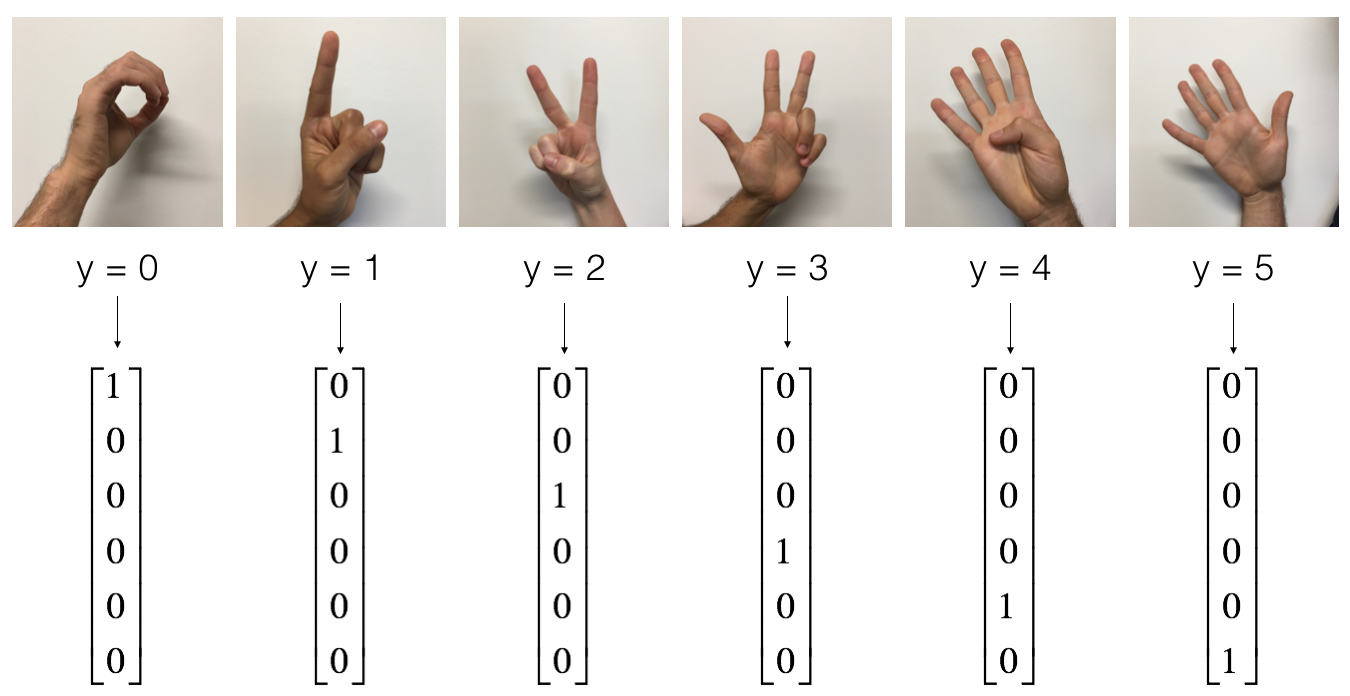

In [0]:
Image("images/signs_data_kiank.png",width=800)


<img src="images/signs_data_kiank.png" style="width:450px;height:250px;">
<caption><center> <u> <font color='purple'> **Figure 6** </u><font color='purple'>  : **SIGNS dataset** </center></caption>


In [13]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [14]:
model.fit(X_train, Y_train, epochs = 2, batch_size = 32)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/2

1080/1080 [==============================] - 20s 19ms/step - loss: 2.5318 - acc: 0.3769
Epoch 2/2
1080/1080 [==============================] - 3s 3ms/step - loss: 1.3648 - acc: 0.6713


**Expected Output**:

<table>
    <tr>
        <td>
            ** Epoch 1/**
        </td>
        <td>
           loss: between 1 and 5, acc: between 0.2 and 0.5.
        </td>
    </tr>
    <tr>
        <td>
            ** Epoch 2/**
        </td>
        <td>
           loss: between 1 and 5, acc: between 0.2 and 0.5.
        </td>
    </tr>

</table>

In [15]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

120/120 [==============================] - 2s 14ms/step
Loss = 13.43174622853597
Test Accuracy = 0.16666666716337203


We get a lot better performance when we train for ~20 epochs.

In [16]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

120/120 [==============================] - 0s 1ms/step
Loss = 13.43174622853597
Test Accuracy = 0.16666666716337203


ResNet50 is a powerful model for image classification when it is trained for an adequate number of iterations. 


## 4 - Test on your own image

    1. Add your image to the "images" folder
    2. Run the code and check if the algorithm is right! 

Input image shape: (1, 64, 64, 3)
class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = 
[[1. 0. 0. 0. 0. 0.]]


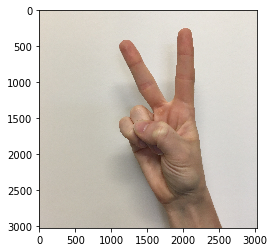

In [25]:
img_path = 'images/my_image.jpg'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)
my_image = plt.imread(img_path)
imshow(my_image)
print("class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ")
print(model.predict(x))

You can also print a summary of your model by running the following code.
Please have a look at the model and its paramter number.

In [0]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 64, 64, 3)     0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, 70, 70, 3)     0           input_1[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 32, 32, 64)    9472        zero_padding2d_1[0][0]           
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 32, 32, 64)    256         conv1[0][0]                      
___________________________________________________________________________________________

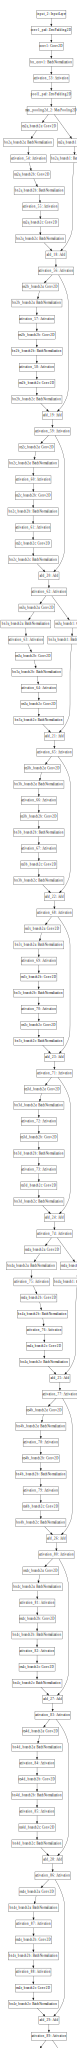

In [28]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

You can try to classify your own image with ResNet50 pre-trained model on imagenet.

In [26]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

model = ResNet50(weights='imagenet')



102858752/102853048 [==============================] - 4s 0us/step


In [27]:
img_path = 'image2.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)

print('Predicted:', decode_predictions(preds, top=5)[0])

40960/35363 [==================================] - 0s 0us/step
Predicted: [('n03803284', 'muzzle', 0.008128203), ('n02109047', 'Great_Dane', 0.006388174), ('n02504013', 'Indian_elephant', 0.0057102996), ('n02090379', 'redbone', 0.005618565), ('n02096585', 'Boston_bull', 0.005568743)]
